# Confeccion de la red en NetworkX

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite 



In [2]:
%pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [202]:
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_grafo(grafo):
    pos = nx.circular_layout(grafo, scale=-1)
    nx.draw(grafo, pos, with_labels=True, node_size=10, font_size=8)
    plt.savefig('grafo_visualizado.png', dpi=300)
    plt.show()




## Leeremos desde el archvio para crear la red

In [7]:
# Especifica la ruta de tu archivo TSV
ruta_archivo = 'red_fenotipos_genes_dysgraphia.txt'

# Lee el archivo TSV y crea un grafo bipartito
    
df = pd.read_csv(ruta_archivo, sep='\t')

# Crea un grafo bipartito
G = nx.Graph()

# Agregar nodos y aristas al grafo bipartito
for _, row in df.iterrows():
    gene_symbol = row['gene_symbol']
    hpo_id = row['hpo_id']
    G.add_node(gene_symbol, bipartite=0)  # genes en la primera partición
    G.add_node(hpo_id, bipartite=1)       # HPO IDs en la segunda partición
    G.add_edge(gene_symbol, hpo_id)

## Grafo Centrado 
Crearemos un subgrafo centrado en el hpo de la disgrafia y reducirlo a un numero de pasos para poder esudiarlo mejor. Elegimos incluir en el subgrafo solo los nodos que estén como mucho a 2 nodos del centro, asi tendremos los genes inmediatamente relacionados y los fenotipos a un solo paso.

In [9]:
target_hpo = 'HP:0010526'

# Calcular las longitudes de los caminos más cortos desde el nodo de interés
shortest_paths = nx.single_source_shortest_path_length(G, target_hpo)

# Filtrar nodos a 2 pasos o menos 
filtered_nodes2 = [node for node, distance in shortest_paths.items() if distance <= 2]

# Crear un subgrafo con los nodos filtrados
subgraph2 = G.subgraph(filtered_nodes2)

## Proyeccion red de Hps
Proyectaremos el grafo, dejando solo los hps; en otras palabras, eliminaremos los genes intermedios para contruir un grafo en el que unicamente esten los hps relaionados con la disgrafia, dejando fuera aquellos con los que no guarda una relacion directa.

In [129]:
## tomamos de la red todos los nodos de tipo hpo del grafo
hpo_ids  = bipartite.sets(subgraph2)[0]

In [12]:
hpo_projection = nx.bipartite.projected_graph(subgraph2, hpo_ids )

## Proyeccion red de Genes

In [33]:
genes= bipartite.sets(subgraph2)[1]
gene_projection = nx.bipartite.projected_graph(subgraph2, genes )

## Hpos altamente relacionados con la dysgraphia 


In [146]:
#usamos la lista de nodos (que son los nodos a un paso del hpo , sacada de la pryeccion de hpos) 
lista_de_nodos = list(hpo_projection.nodes())
df_un_paso=df[df['hpo_id'].isin(lista_de_nodos)]
## filtramos tambien con la lista de genes relacionados con la d
df_un_paso=df_un_paso[df['gene_symbol'].isin(gene_projection.nodes())]
df_un_paso=df_un_paso[["ncbi_gene_id","gene_symbol","hpo_id","hpo_name"]].drop_duplicates()

/var/folders/76/mxbv2rc56k12dg4mcx60_c5h0000gn/T/ipykernel_1858/219026415.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_un_paso=df_un_paso[df['gene_symbol'].isin(gene_projection.nodes())]


Ahora, teniendo una lista de los hpos que rodean a la disgrafia (estan a un paso de el) y los genes con los que se relaciona, intentaremos ver mediante cuantos genes se relacionan.
dysgrafia esta relacionado con los 51 genes presentes en el grafo, de forma que miraremos ahora, en el dataframe entero, cuantos genes se relacionan con cadad hpo, si todos ellos estan relacinoados con disgrafia, al final deben ser intermediarios entre este hpo y nuesto hpo de estudio.

In [149]:
df_un_paso['relaciones_con_dysgraphia']=1

resultado=df_un_paso.groupby('hpo_id').agg({'hpo_name': 'first', 'relaciones_con_dysgraphia': 'sum'}).reset_index().sort_values(by="relaciones_con_dysgraphia", ascending = False)


In [249]:
ruta_relativa =  os.path.join(os.path.dirname(os.getcwd()), 'results')+"/"
resultado.to_csv(ruta_relativa+'Hpos_rank_relacionados.csv', index=False)

In [185]:
resultado

,hpo_id,hpo_name,relaciones_con_dysgraphia
1036,HP:0010526,Dysgraphia,51
337,HP:0001288,Gait disturbance,45
201,HP:0000716,Depression,44
322,HP:0001260,Dysarthria,42
215,HP:0000739,Anxiety,42
...,...,...,...
663,HP:0002721,Immunodeficiency,1
664,HP:0002723,Absence of bactericidal oxidative respiratory ...,1
667,HP:0002729,Follicular hyperplasia,1
668,HP:0002731,Decreased lymphocyte apoptosis,1


In [210]:
# obtengamos aquellos uqe esten relacionados por 25 o mas genes 
top25=resultado[resultado["relaciones_con_dysgraphia"]>=45]
lista25=top25["hpo_id"].tolist()
genesList = df_un_paso[df_un_paso["hpo_id"]== 'HP:0010526'].sort_values(by= "gene_symbol")["gene_symbol"].drop_duplicates().tolist()

listaTotal=lista25+genesList
grafoMasRelacion = G.subgraph(listaTotal)

metodologia -- 
1. que he usado 
2. como lo he usado 
3. hazz un grafo con los 20 hpos mas relacionados 


In [255]:
import os
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_grafo_bipartito_circular(grafo, dpi=300):
  

    # Asegurarse de que la carpeta de resultados exista en el mismo nivel que la carpeta de código
    carpeta_guardado = os.path.join(os.path.dirname(os.getcwd()), 'results')
    if not os.path.exists(carpeta_guardado):
        os.makedirs(carpeta_guardado)

    # Dividir nodos por partición
    nodos_genes = [nodo for nodo, particion in nx.get_node_attributes(grafo, 'bipartite').items() if particion == 0]
    nodos_hpos = [nodo for nodo, particion in nx.get_node_attributes(grafo, 'bipartite').items() if particion == 1]

    # Crear un layout circular
    pos = nx.circular_layout(grafo)

    # Dibujar nodos y aristas
    nx.draw_networkx_nodes(grafo, pos, nodelist=nodos_genes, node_color='blue', label='Genes', node_size=50)
    nx.draw_networkx_nodes(grafo, pos, nodelist=nodos_hpos, node_color='red', label='HPOs', node_size=50)
    nx.draw_networkx_edges(grafo, pos, edge_color='gray')

    # Etiquetas
    labels = {nodo: nodo for nodo in grafo.nodes}
    nx.draw_networkx_labels(grafo, pos, labels, font_size=8)

    # Mostrar leyenda
    plt.legend()

    # Guardar el gráfico en la carpeta especificada con nombre de archivo y resolución
    nombre_archivo = 'grafo_Hpos_alta_relacion.png'
    ruta_guardado = os.path.join(carpeta_guardado, nombre_archivo)
    plt.savefig(ruta_guardado, dpi=dpi)
 

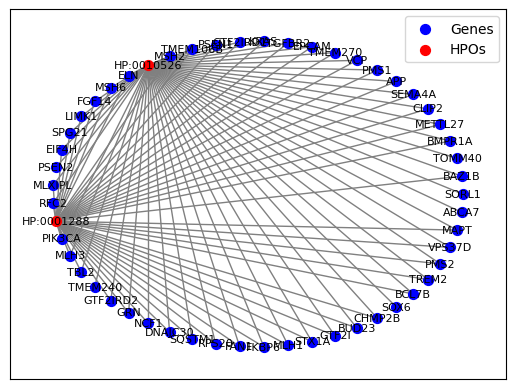

In [256]:
visualizar_grafo_bipartito_circular(grafoMasRelacion)

Ruta relativa de results: /Users/davidcubillosdeltoro/Desktop/trabajo biologia de sistemas /HPO_Dysgraphia/results
